# **1. Dataset Preparation**

In [ ]:
from datasets import load_dataset

# Load a small slice (e.g., first 500 examples) to keep it light
dataset = load_dataset("sizhkhy/open-images-captions-micro", split="train")

print(dataset)
print(dataset[0])

Dataset({
    features: ['caption', 'image'],
    num_rows: 4984
})
{'caption': 'This picture shows few people seated on the sofa and we see a human hand holding beer bottle and we see a glass and we see clothes on the back and we see smile on their faces.', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x792FE87735F0>}


# **2. Preprocessing and Feature Extraction**

**2.1Caption Preprocessing**

In [ ]:
for i in range(5):
    print(dataset[i]["caption"])

This picture shows few people seated on the sofa and we see a human hand holding beer bottle and we see a glass and we see clothes on the back and we see smile on their faces.
In this image there are some trees on the bottom of this image and there is a sky on the top of this image.
In this picture we can see four chairs in the grass. Those are in different colors like black, green, blue, and red. And on the background there are trees.
These two persons sitting and playing musical instruments and this person standing and holding guitar. We can see microphones with stand. On the background we can see curtain.
There are groups of people standing. This looks like an iron grill. I can see a building with the windows and a door. There are two people sitting on the stairs. On the right side of the image, that looks like a board, which is attached to a building wall. Here is a pole. I think this is a road.


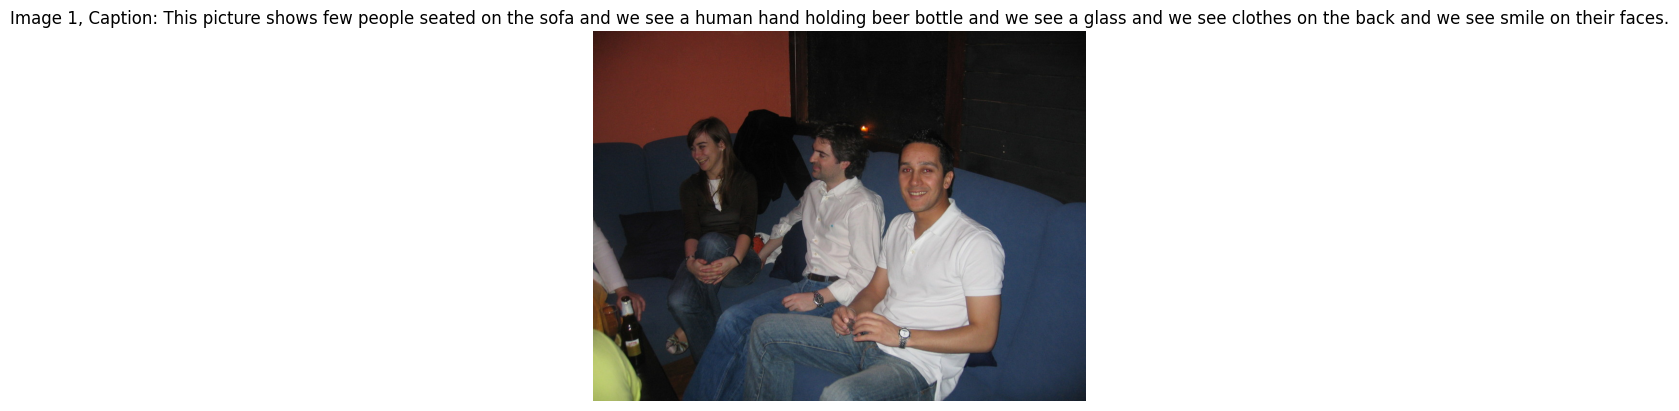

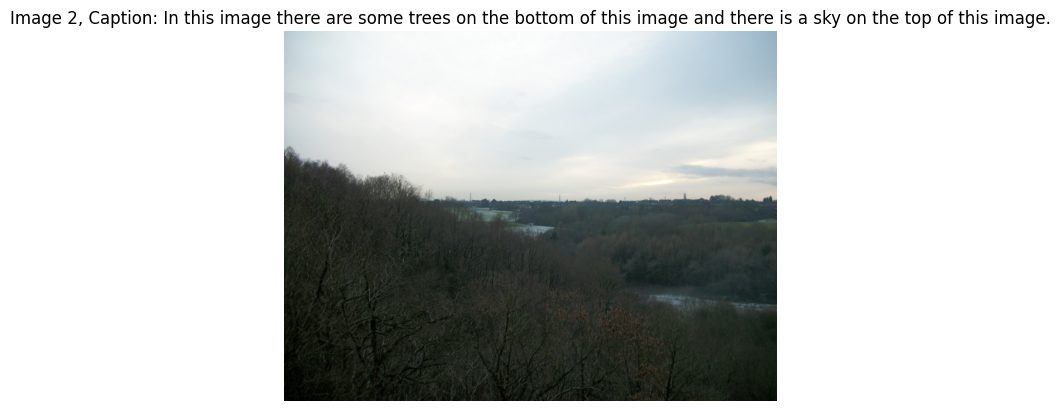

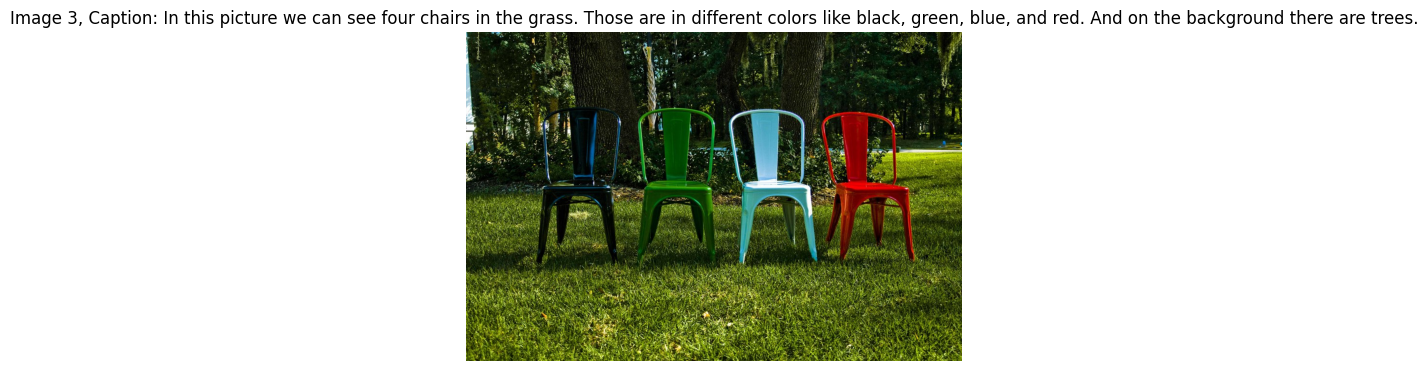

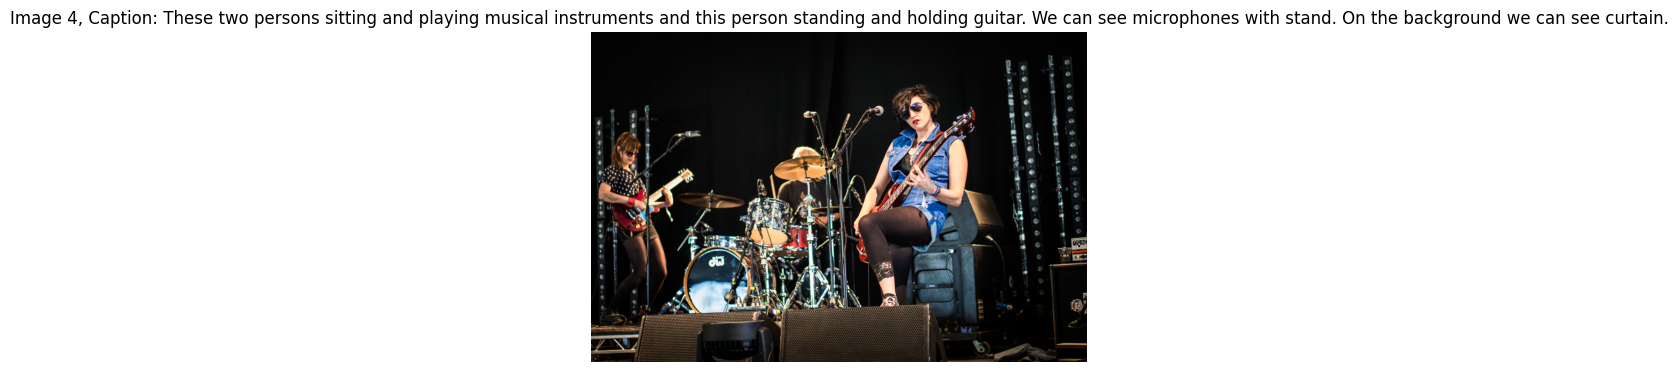

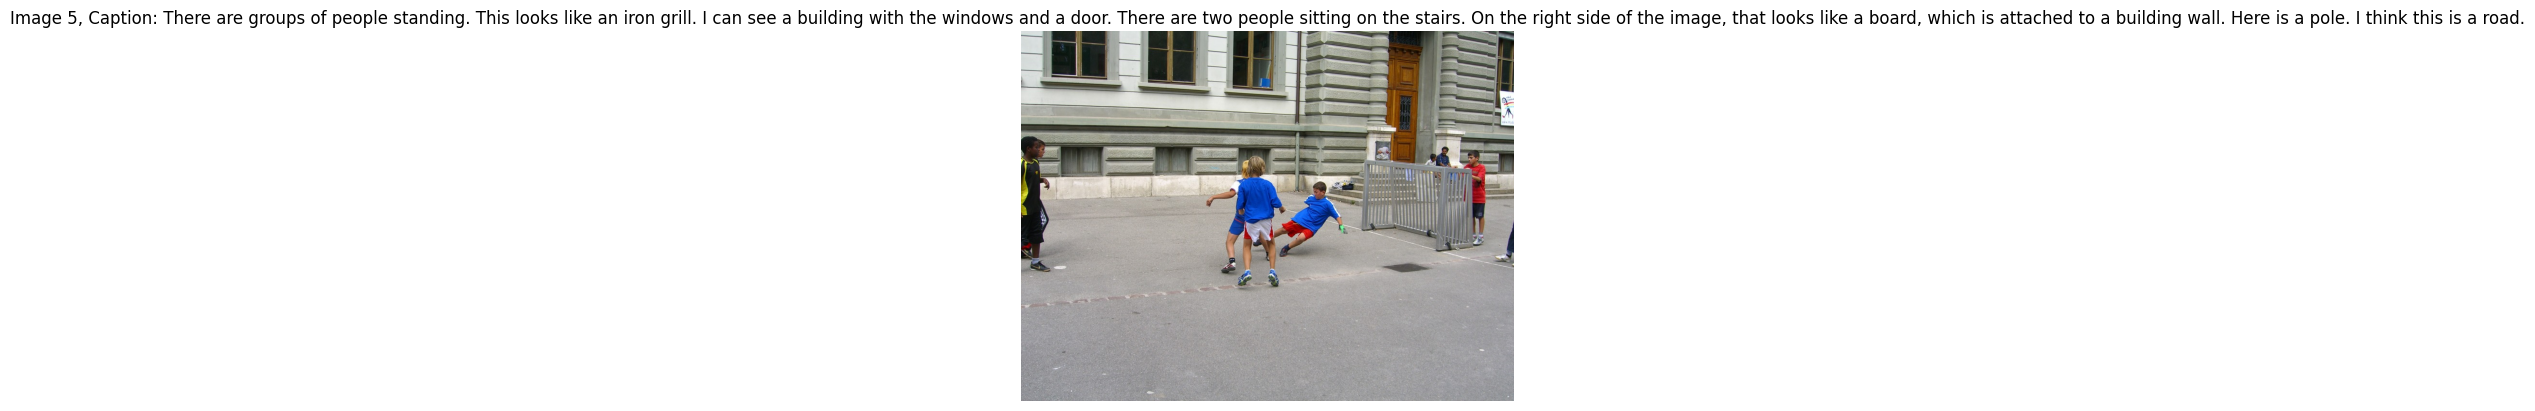

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Used for potential conversions/checks

# Iterate and display the first 5 images
for i in range(5):
    # 1. Access the image object/tensor
    image_data = dataset[i]["image"]

    # 2. Convert to NumPy array (if it's a TensorFlow Tensor)
    # The .numpy() method is used to convert a TensorFlow Tensor to a NumPy array.
    if hasattr(image_data, 'numpy'):
        image_array = image_data.numpy()
    else:
        # If it's already a NumPy array (or something else directly displayable)
        image_array = image_data

    # 3. Display the image
    plt.figure() # Creates a new figure for each image
    plt.imshow(image_array)
    plt.title(f"Image {i+1}, Caption: {dataset[i]["caption"]}")
    plt.axis('off') # Hides the coordinate axes for a clean view
    plt.show() # Displays the plot

**2.1.1 Text Cleaning Rules**

In [ ]:
import re
import string

def clean_caption(caption):
    caption = caption.lower()                                                  # lowercase
    caption = re.sub(r'[%s]' % re.escape(string.punctuation), '', caption)     # remove punctuation
    caption = re.sub(r'\d+', '', caption)                                      # remove digits
    caption = caption.strip()                                                  # remove extra spaces
    caption = '<start> ' + caption + ' <end>'                                  # add tokens
    return caption

In [ ]:
captions = [clean_caption(example["caption"]) for example in dataset]
for caption in captions[:5]:
  print(caption)
print(len(captions))

<start> this picture shows few people seated on the sofa and we see a human hand holding beer bottle and we see a glass and we see clothes on the back and we see smile on their faces <end>
<start> in this image there are some trees on the bottom of this image and there is a sky on the top of this image <end>
<start> in this picture we can see four chairs in the grass those are in different colors like black green blue and red and on the background there are trees <end>
<start> these two persons sitting and playing musical instruments and this person standing and holding guitar we can see microphones with stand on the background we can see curtain <end>
<start> there are groups of people standing this looks like an iron grill i can see a building with the windows and a door there are two people sitting on the stairs on the right side of the image that looks like a board which is attached to a building wall here is a pole i think this is a road <end>
4984


In [ ]:
import numpy as np

lengths = [len(c.split()) for c in captions]
print(f"Average caption length: {np.mean(lengths):.1f} words")
print(f"Max caption length: {np.max(lengths)}")

Average caption length: 37.6 words
Max caption length: 154


**2.1.2 Tokenization **bold text** & Vocabulary Building**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Limit vocabulary size to most frequent 5000 words
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")

# Fit tokenizer on cleaned captions
tokenizer.fit_on_texts(captions)

In [ ]:
sequences = tokenizer.texts_to_sequences(captions)

In [ ]:
print(captions[0])
print(sequences[0][:10])  # show first 10 tokens

<start> this picture shows few people seated on the sofa and we see a human hand holding beer bottle and we see a glass and we see clothes on the back and we see smile on their faces <end>
[11, 15, 20, 225, 24, 26, 281, 10, 2, 228]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

Vocabulary size: 2762


In [ ]:
from collections import Counter

# Convert the OrderedDict to a Counter object
word_counts_counter = Counter(tokenizer.word_counts)

# Use most_common() on the Counter object
print(word_counts_counter.most_common(20))

[('the', 15569), ('a', 9570), ('in', 9222), ('and', 8370), ('there', 7742), ('is', 7630), ('see', 6808), ('can', 6457), ('on', 5189), ('start', 4984), ('end', 4984), ('we', 4660), ('image', 4507), ('this', 4411), ('are', 4359), ('of', 3870), ('i', 2400), ('background', 2399), ('picture', 1840), ('some', 1668)]


In [ ]:
from keras.utils import pad_sequences

max_length = max(len(seq) for seq in sequences)
min_length = min(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print(f"Max sequence length:{max_length}, Min sequence length:{min_length}")

Max sequence length:154, Min sequence length:6


**2.2 Image Feature Extraction using CNN Encoder (InceptionV3)**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
# Load pre-trained InceptionV3
base_model = InceptionV3(weights='imagenet')

# Remove the classification head
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

In [ ]:
def extract_features(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((299, 299))                   # InceptionV3 expects 299x299
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img, verbose=0)
    return features

In [ ]:
image_features = [extract_features(example['image']) for example in dataset]

KeyboardInterrupt: 

In [ ]:
np.save('image_features.npy', image_features)

In [ ]:
image_features = np.array([f.reshape(2048) for f in image_features])
print(image_features.shape)

(4984, 2048)


In [ ]:
features = np.load('image_features.npy', allow_pickle=True)

# **3 Model Architecture — CNN + LSTM Fusion**

        [InceptionV3 Encoder]      [LSTM Decoder]
Image → 2048-dim feature vector →  (uses <start> tokens → predicts next words)


Architectural components

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout

inputs1 = Input(shape=(2048,), name='image_input') # Explicitly define shape and name
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

Text sequence branch, Output shape → (256,).

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM

inputs2 = Input(shape=(max_length,), name='caption_input') # Explicitly define shape and name
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = LSTM(256, use_cudnn=False)(se1)

Fusion and output layer

In [ ]:
from tensorflow.keras.layers import add

decoder1 = add([fe2, se2])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

Build and compile the model

Loss: categorical cross-entropy (next-word prediction)

Optimizer: Adam (fast convergence)

Output: probability distribution over words (softmax)

(image_features, partial_caption_input) → next_word_output

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer

# Create an Adam optimizer instance with the desired learning rate
optimizer = Adam(learning_rate=1e-4)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Compile the model using the optimizer instance
model.compile(loss='categorical_crossentropy', optimizer=optimizer) # Pass the optimizer instance
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 154)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2048)      │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 154, 256)  │    707,072 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 154)       │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256)       │    525,312 │ embedding_6[0][0… │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_15[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 2762)      │    709,834 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,532,554 (9.66 MB)

 Trainable params: 2,532,554 (9.66 MB)

 Non-trainable params: 0 (0.00 B)

# **4: Model Training and Evaluation**

**Building the Data Generator**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
def data_generator(features, captions, tokenizer, max_length, vocab_size, batch_size=32):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for i, caption in enumerate(captions):
            feature = features[i].reshape(2048)  # ✅ forces (2048,)
            seq = tokenizer.texts_to_sequences([caption])[0]

            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
                n += 1

                if n == batch_size:
                    yield ((np.array(X1), np.array(X2)), np.array(y))
                    X1, X2, y = list(), list(), list()
                    n = 0

In [ ]:
(X_img, X_seq), y_batch = next(generator)
print(X_img.shape, X_seq.shape, y_batch.shape)

(32, 2048) (32, 154) (32, 2762)


In [ ]:
generator = data_generator(
    features=image_features,
    captions=captions,            # your cleaned list of captions
    tokenizer=tokenizer,
    max_length=max_length,
    vocab_size=vocab_size,
    batch_size=32
)

steps_per_epoch = len(captions) // 32

model.fit(generator, epochs=60, steps_per_epoch=steps_per_epoch, verbose=1)

Epoch 1/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 2.0929
Epoch 2/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.0928
Epoch 3/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 2.0263
Epoch 4/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.1482
Epoch 5/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.1918
Epoch 6/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.2787
Epoch 7/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.2514
Epoch 8/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.1877
Epoch 9/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.1524
Epoch 10/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.1875
Epoch 11/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.1320
Epoch 12/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.1646
Epoch 13/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 2.1728
Epoch 14/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.2914
Epoch 15/60
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s

# **5. Caption Generation (Inference)**

Input: image feature + 'start'

Predict next word → append it → feed back in.

Repeat until 'end' or max_length reached.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sample_with_temperature(preds, temperature=0.8, k=5):
    """
    Selects the next token index using top-k sampling with temperature scaling.
    """
    preds = np.squeeze(preds)
    # avoid log(0)
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    # take top-k
    top_indices = exp_preds.argsort()[-k:][::-1]
    probs = exp_preds[top_indices]
    probs = probs / np.sum(probs)
    # sample one index according to adjusted probabilities
    return np.random.choice(top_indices, p=probs)


def generate_caption(model, tokenizer, photo_feature, max_length=40,
                     temperature=0.5, top_k=5):
    """
    Generates a caption for a given image feature vector.
    """
    caption = "<start>"

    for i in range(max_length):
        # convert caption so far to integer sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')

        # predict next-word probabilities
        yhat = model.predict([photo_feature.reshape((1, 2048)), seq], verbose=0)

        # sample next token index
        next_index = sample_with_temperature(yhat, temperature=temperature, k=top_k)

        # convert index → word
        word = next((w for w, idx in tokenizer.word_index.items() if idx == next_index), None)
        if word is None:
            break

        if word in caption.split()[-3:]:  # if repeated in last 3 words
          continue  # skip this word

        if '<end>' in tokenizer.word_index:
          end_idx = tokenizer.word_index['<end>']
          if yhat[0][end_idx] > 0.2:   # 0.2 = threshold, tune as needed
            break

        # stop on <end>
        if word == "<end>":
            break

        caption += " " + word

    # clean up tokens
    caption = caption.replace("<start>", "").split("<end>")[0].strip()
    return caption

Generate for a new image

In [ ]:
i = 6  # choose any test image index
photo_feature = np.squeeze(image_features[i])

generated_caption = generate_caption(
    model, tokenizer, photo_feature,
    max_length=40,
    temperature=0.5, top_k=5
)

print("Generated Caption:", generated_caption)
print("Actual Caption:", captions[i])

Generated Caption: in this image there is a person standing on the ground and in the background there is a wall and there is a wall and there is a wall end and a wall end and some other objects end and
Actual Caption: <start> in this image i can see two persons are standing on the road in the background i can see buildings trees and a fence this image is taken may be during night on the road <end>


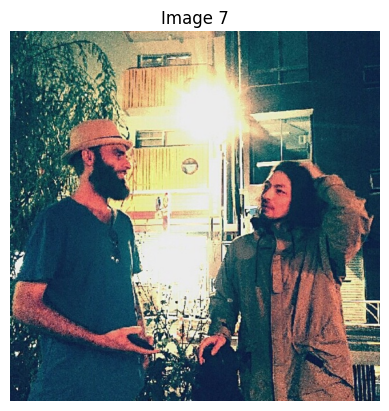

In [ ]:
image_data = dataset[i]["image"]

# 2. Convert to NumPy array (if it's a TensorFlow Tensor)
# The .numpy() method is used to convert a TensorFlow Tensor to a NumPy array.
if hasattr(image_data, 'numpy'):
  image_array = image_data.numpy()
else:
# If it's already a NumPy array (or something else directly displayable)
    image_array = image_data

# 3. Display the image
plt.figure() # Creates a new figure for each image
plt.imshow(image_array)
plt.title(f"Image {i+1}")
plt.axis('off') # Hides the coordinate axes for a clean view
plt.show() # Displays the plot

# **6. Model Evaluation**

In [ ]:
!pip install nltk
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
smooth = SmoothingFunction().method1

def evaluate_bleu(model, tokenizer, features, captions, n=10):
    scores = []
    for i in range(n):
        ref = [captions[i].replace('<start>', '').replace('<end>', '').split()]
        photo_feature = np.squeeze(features[i])
        pred = generate_caption(model, tokenizer, photo_feature,
                                max_length=40, temperature=0.5, top_k=3)
        cand = pred.split()
        bleu1 = sentence_bleu(ref, cand, weights=(1, 0, 0, 0), smoothing_function=smooth)
        bleu2 = sentence_bleu(ref, cand, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        scores.append((bleu1, bleu2))
        print(f"Image {i}: BLEU-1 = {bleu1:.3f}, BLEU-2 = {bleu2:.3f}")
        print(f" Generated: {pred}")
        print(f" Actual: {captions[i]}\n")
    return scores

scores = evaluate_bleu(model, tokenizer, image_features, captions, n=10)

Image 0: BLEU-1 = 0.269, BLEU-2 = 0.086
 Generated: in this image we can see a man standing and smiling he is holding a bag in his hand and he is holding a camera in his hand and there is a man holding
 Actual: <start> this picture shows few people seated on the sofa and we see a human hand holding beer bottle and we see a glass and we see clothes on the back and we see smile on their faces <end>

Image 1: BLEU-1 = 0.300, BLEU-2 = 0.144
 Generated: in this image i can see a building and the sky is in blue color end in the background i can see the sky end clouds and the sky end
 Actual: <start> in this image there are some trees on the bottom of this image and there is a sky on the top of this image <end>

Image 2: BLEU-1 = 0.375, BLEU-2 = 0.246
 Generated: in this picture i can see a woman wearing black color dress is holding a camera in the background i can see a wall and the sky end and the sky end
 Actual: <start> in this picture we can see four chairs in the grass those are in diff